In [1]:
import pandas as pd
import ast
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
recipes_df = pd.read_csv('RAW_recipes.csv')
interactions_df = pd.read_csv('RAW_interactions.csv')

In [3]:
nutritions_list = ["calories", "total_fat", "sugar", "sodium", "protein", "sat_fat", "carbs"]

In [4]:
recipes_df['nutrition'] = recipes_df['nutrition'].apply(ast.literal_eval)

In [5]:
recipes_df[nutritions_list] = pd.DataFrame(recipes_df.nutrition.values.tolist(), index=recipes_df.index)

In [6]:
recipes_df = recipes_df.drop(['nutrition'], axis=1)

In [7]:
recipes_df.isnull().any()

name               True
id                False
minutes           False
contributor_id    False
submitted         False
tags              False
n_steps           False
steps             False
description        True
ingredients       False
n_ingredients     False
calories          False
total_fat         False
sugar             False
sodium            False
protein           False
sat_fat           False
carbs             False
dtype: bool

In [8]:
recipes_df = recipes_df.dropna(axis=0).reset_index(drop=True)

In [9]:
interactions_df.isnull().any()

user_id      False
recipe_id    False
date         False
rating       False
review        True
dtype: bool

In [10]:
interactions_df = interactions_df.dropna(axis=0)

In [11]:
complete_df = recipes_df.merge(interactions_df, left_on='id', right_on='recipe_id')

In [12]:
complete_df = complete_df[complete_df['minutes'] <= 500].reset_index(drop=True)

In [13]:
complete_df['minutes'].hist()

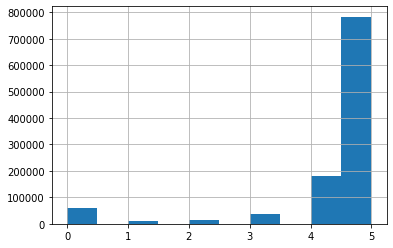

In [14]:
complete_df['rating'].hist()

In [15]:
# Most reviewed recipe
complete_df.groupby('name').count().idxmax()[0]

'best banana bread'

### How number of reviews related to n_steps, time, each nutrition component and the ratings of others?

Here we try to get the relation between number of reviews and different features, we hope to see that recipes that are more time consuming receive less reviews since less people try them.

In [16]:
num_reviews_df = complete_df.groupby('id').count()

In [17]:
df = recipes_df.merge(num_reviews_df[['name']].copy(), left_on='id', right_on='id')\
               .rename(columns={'name_y': 'count'})[['count', 'minutes', 'n_steps', 'n_ingredients'] + nutritions_list]

In [18]:
df = df.rename(columns={'count': 'num_reviews'})

In [22]:
# the following two functions are from the internet to help plot the heatmaps
# https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

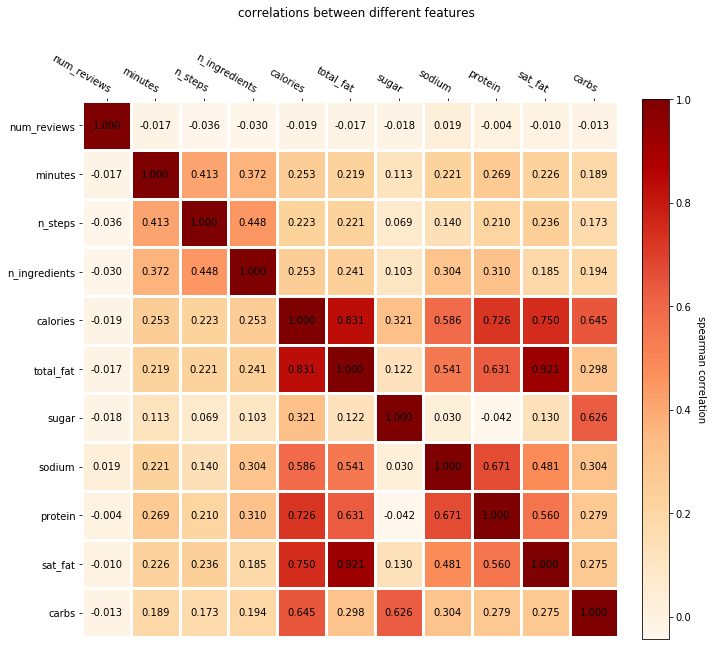

In [26]:
# Plotting setting
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('correlations between different features')        
im, cbar = heatmap(data=df.corr(method='spearman'), row_labels=df.columns, col_labels=df.columns, ax=ax,
                   cmap="OrRd", cbarlabel="spearman correlation")
texts = annotate_heatmap(im, valfmt="{x:.3f}", threshold=1)
fig.tight_layout()
plt.show()

We can see that the number of reviews has little to do with other features and it turns out to be somewhat random. In contrast, we find some strong correlation between different nutrition components in the recipe (e.g. total fat with calories(food with high fat usually has high calories), protein with calories, total fat with saturated fat, carbs with calories)

### Get the taste of each recipe

To get an estimation of the taste of different dishes, we search for words indicating different types of taste in the tags, reviews and descriptions. Then we collect the taste of each recipe in a set as a new column.

In [118]:
# Words for different taste catagory
taste_word_dict = {'sour': ['acid', 'acidic', 'sour', 'tart', 'vinegary', 'citrus', 'lemon'],
                   'bitter': ['bitter', 'harsh'],
                   'salty': ['brackish', 'salty', 'briny', 'saline'],
                   'sweet': ['dulcet', 'sweet', 'honeyed', 'dulcified', 'edulcorated', 'sweetened', 'candied','syrupy', 'sugarcoated', 'nectarous', 'candy', 'fudge'],
                   'spicy': ['spicy','peppery', 'piquant', 'pungent', 'burning', 'fiery', 'gingery', 'sharp', 'stinging', 'zesty', 'sugary', 'chili', 'chutneys', 'curries', 'peppers']}

In [119]:
# Take out 
for taste in taste_word_dict.keys():
    recipes = complete_df.review.str.lower().apply(lambda x: any(word in x for word in taste_word_dict[taste]))\
              | complete_df.tags.apply(lambda x: any(word in x for word in taste_word_dict[taste]))\
              | complete_df.description.str.lower().apply(lambda x: any(word in x for word in taste_word_dict[taste]))
    complete_df.taste.loc[recipes] = complete_df[recipes].taste.apply(lambda l:l + [taste])

/Users/jiahuawu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [120]:
taste_df = complete_df[complete_df.taste.apply(lambda l: len(l) > 0)].groupby(['id', 'name']).agg({'taste':'sum'})
taste_df['taste'] = taste_df['taste'].apply(set)

In [123]:
taste_df.to_csv('taste_df.csv')

In [128]:
taste_recipes_df = taste_df.merge(recipes_df, left_on='id', right_on='id').drop('taste_y', axis=1).rename(columns={'taste_x': 'taste'})

In [ ]:
taste_recipes_df.to_csv('recipe+taste.csv')

### Representative Taste of Recipe of Each Country

In [26]:
taste_recipes_df = pd.read_csv('recipe+taste.csv')

In [139]:
recipes_country_df = pd.read_pickle('recipe_country.pkl')

In [143]:
cols_to_use = recipes_country_df.columns.difference(taste_recipes_df.columns)
cols_list = cols_to_use.tolist()
cols_list.append('id')
cols_list.remove('nutrition')

In [145]:
taste_continent_df = recipes_country_df[['continent', 'country', 'id']].merge(taste_recipes_df[['taste', 'id']], left_on='id', right_on='id')
taste_continent_df.taste = taste_continent_df.taste.apply(eval).apply(list)
best_taste_country_df = taste_continent_df.explode('taste').groupby(['country', 'taste'])['id'].count()\
                        .groupby('country').nlargest(1).to_frame().droplevel(0).reset_index()
best_taste_country_df = best_taste_country_df.rename(columns={'id': 'count'})

### Drawing the corresponding choropleth map

In [150]:
import geopandas
from matplotlib import cm
%matplotlib inline

In [151]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [152]:
invalid_indices = []
for ind, country in enumerate(best_taste_country_df.country):
    if country not in world.name.tolist():
        invalid_indices.append(ind)

In [155]:
best_taste_country_df = best_taste_country_df[~best_taste_country_df.country.isin(['Caribbean', 'Hawaii', 'Melanesia', 'Polynesia'])].reset_index(drop=True)

In [156]:
map_country_name = {'America': 'United States of America', 'Korea': 'South Korea', 'Lao':'Laos', 'Lybia': 'Libya',
                   'Melanesia': 'Malaysia', 'Morocca': 'Morocco', 'UK': 'United Kingdom'}

In [157]:
def helper(country):
    if country in map_country_name:
        return map_country_name[country]
    else:
        return country

In [158]:
best_taste_country_df.country = best_taste_country_df.country.apply(helper)

In [159]:
merged = world.set_index('name').join(best_taste_country_df.set_index('country'))

In [160]:
merged.drop('count', axis=1, inplace=True)

In [161]:
merged.taste = merged.taste.fillna('No Data')

In [166]:
color_dict = {}
color_dict['No Data'] = 'lightgray'
color_dict['spicy'] = 'red'
color_dict['sour'] = 'green'
color_dict['sweet'] = 'blue'

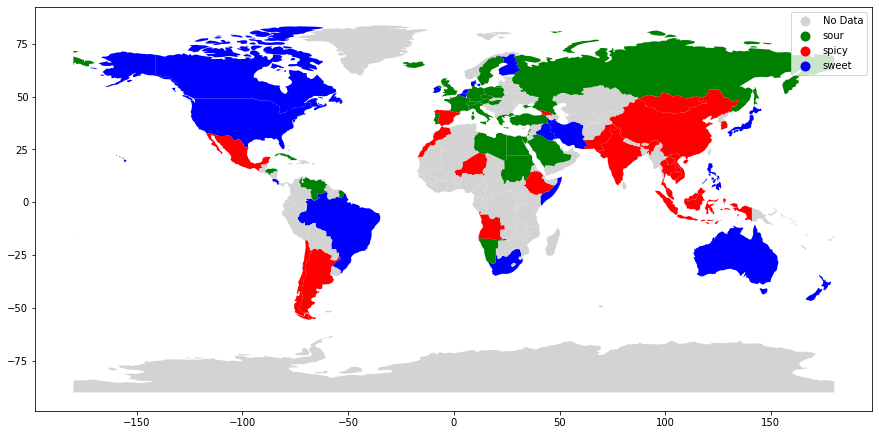

In [182]:
from matplotlib import colors
cmap = colors.ListedColormap(['lightgray', 'green', 'red', 'blue'])
merged.plot(column='taste', categorical=True, legend=True, figsize=(15,15), cmap=cmap)

We can see that spicy recipes are related to the southeast Asia, Mexico, India, China and Spain, which is in line with  common sense. Similarly, sweet recipes are related to north America, Oceania. What is surprising is the representative taste of the recipes of most of the european countries is sour.

## Scrape from food.com to complete the usage of each ingredient

Here we scrape the data from food.com to complete the dose of each ingredient which is missing in the original dataset. We intend to use them to build a regression model capable of predicting the amount of nutrients based on the provided cooking method, ingredients and their amount. 

In [11]:
taste_recipes_df = pd.read_csv('recipe+taste.csv')

In [12]:
cooking_method_recipes_df = pd.read_pickle('recipe_cooking.pkl')

In [4]:
training_df = taste_recipes_df[['id', 'taste', 'ingredients', 
                                     'calories', 'total_fat', 'sugar', 'sodium', 'protein', 'sat_fat', 'carbs']]\
                   .merge(cooking_method_recipes_df[['id', 'method', 'name']], left_on='id', right_on='id')

In [6]:
from recipe_scrapers import scrape_me

In [16]:
ingredient_dict = {}
failed_url_list = []
counter = 0
for _, series in training_df.iterrows():
    if counter % 100 == 0:
        print('{} requests finished'.format(counter))
    recipe_id = series['id']
    recipe_name = series['name']
    url = 'https://www.food.com/recipe/{}{}?mode=Metric&scaleto=8'.format('-'.join(recipe_name.split()), '-'+str(recipe_id))
    scraper = scrape_me(url)
    if len(scraper.ingredients()) == 0:
        print(url)
        failed_url_list.append(url)
    else:
        ingredient_dict[recipe_id] = scraper.ingredients()
    counter += 1

0 requests finished
100 requests finished
https://www.food.com/recipe/snickers-bar-copycat-3422?mode=Metric&scaleto=8
https://www.food.com/recipe/hooters-buffalo-wings-3603?mode=Metric&scaleto=8
200 requests finished
https://www.food.com/recipe/bailey-s-original-irish-cream-by-todd-wilbur-5008?mode=Metric&scaleto=8
300 requests finished
https://www.food.com/recipe/chili-s-fajitas-by-todd-wilbur-8595?mode=Metric&scaleto=8
400 requests finished
https://www.food.com/recipe/chili-s-fajitas-by-todd-wilbur-8595?mode=Metric&scaleto=8
500 requests finished
600 requests finished
700 requests finished
800 requests finished
900 requests finished
1000 requests finished
1100 requests finished
1200 requests finished
1300 requests finished
1400 requests finished
1500 requests finished
1600 requests finished
1700 requests finished
1800 requests finished
https://www.food.com/recipe/p-f-chang-s-chicken-lettuce-wraps-by-todd-wilbur-15865?mode=Metric&scaleto=8
1900 requests finished
https://www.food.com/r

15000 requests finished
https://www.food.com/recipe/tsr-version-of-t-g-i-friday-s-black-bean-soup-by-todd-wilbur-102274?mode=Metric&scaleto=8
15100 requests finished
15200 requests finished
15300 requests finished
15400 requests finished
15500 requests finished
15600 requests finished
https://www.food.com/recipe/top-secret-recipes-version-of-baja-fresh-salsa-by-todd-wilbur-108594?mode=Metric&scaleto=8
https://www.food.com/recipe/top-secret-recipes-version-of-baja-fresh-salsa-by-todd-wilbur-108594?mode=Metric&scaleto=8
15700 requests finished
15800 requests finished
https://www.food.com/recipe/shanghai-wings-copycat-chili-s-by-todd-wilbur-110159?mode=Metric&scaleto=8
https://www.food.com/recipe/yaki-soft-tacos-copycat-by-todd-wilbur-110437?mode=Metric&scaleto=8
15900 requests finished
16000 requests finished
https://www.food.com/recipe/tsr-version-of-breakfast-burritos-mcdonald-s-by-todd-wilbur-111725?mode=Metric&scaleto=8
https://www.food.com/recipe/pizza-dipping-sauces-copycat-papa-jo

34200 requests finished
34300 requests finished
34400 requests finished
34500 requests finished
34600 requests finished
https://www.food.com/recipe/fuddruckers-hamburger-seasoning-by-todd-wilbur-290879?mode=Metric&scaleto=8
34700 requests finished
34800 requests finished
34900 requests finished
35000 requests finished
35100 requests finished
35200 requests finished
35300 requests finished
35400 requests finished
35500 requests finished
35600 requests finished
35700 requests finished
35800 requests finished
35900 requests finished
36000 requests finished
https://www.food.com/recipe/tsr-version-of-burger-king-zesty-onion-ring-sauce-by-todd-wilbur-308329?mode=Metric&scaleto=8
36100 requests finished
36200 requests finished
36300 requests finished
36400 requests finished
36500 requests finished
36600 requests finished
36700 requests finished
36800 requests finished
36900 requests finished
37000 requests finished
37100 requests finished
https://www.food.com/recipe/chipotle-mexican-grill-bar

In [19]:
import json
json = json.dumps(ingredient_dict)
f = open("ingredients.json","w")
f.write(json)
f.close()

In [22]:
import json
json = json.dumps(failed_url_list)
f = open("failed_url.json","w")
f.write(json)
f.close()